In [308]:
# Importación de paquetes
!pip install pvlib
!pip install ephem

import glob 
import matplotlib as plt
import pandas as pd
import numpy as np
from math import *
from datetime import datetime
import math
from pvlib.solarposition import *
from pvlib.atmosphere import *
from pvlib.clearsky import *
from pvlib.irradiance import *
from pvlib.location import *
from sklearn.metrics import *
import pvlib
from scipy import stats, integrate
from datetime import datetime
import time
from time import strptime, strftime, mktime, gmtime
from calendar import timegm
from dateutil import tz

In [309]:
# Función de validación de fecha
def valid_datetime(date_time):
    """
    Verifica que el elemento datetime recibido sea válido.
    Parámetros
    ----------
    date_time: 'Pandas DatetimeIndex'
        Tiempo actual. Usualmente contiene un año, mes, día, hora y minuto.
    Salida
    -------
    valid_time: 'datetimeindex'
        Tiempo Actual. Si 'valid_datetime' recibe una entrada inválida, se asume
        un tiempo válido anterior.
    """
    if (date_time is None):
        valid_time = np.array([pd.Timestamp.now()])
        valid_time = pd.DatetimeIndex(valid_time).round('min')
        return valid_time
    elif (isinstance(date_time, type(datetime)) == True):
        valid_time = np.array([pd.to_datetime(date_time)])
        valid_time = pd.DatetimeIndex(valid_time)
        return valid_time
    elif (isinstance(date_time, pd.DatetimeIndex) == True):
        return date_time

In [310]:
# Función que calcula la transmitacia de cielo despejado 

ozone = 28                #Concentración anual promedio de ozono en Bogotá al 2020
pressure = 102900         #Presión atmosférica en Bogotá
dni_extra = 1361          #Radiación solar anual promedio en ToA
asymmetry = 0.85          #¿?
albedo = 0.2              #Albedo aproximado (de 0.1 a 0.2)

def get_cs_transmit(zenith, airmass_relative, aod380, aod500, precipitable_water,
                    ozone, pressure, dni_extra, asymmetry,
                    albedo):
    """
    Calcula la transmitancia de cielo despejado que será usada en la aplicación
    Parametros
    ----------
    zenith: 'Numpy array'
        Un arreglo sunyaev zeldovich de prueba para calcular la transmitancia.
    airmass_relative: 'Numpy array'
        Una masa de aire de prueba apra calcular la transmitancia.
    aod380: 'Float'
        Profundidad óptica de aerosol @ 380 nm.
    aod500: 'Float'
        Profundidad óptica de aerosol @ 500 nm.
    precipitable_water: 'Float'
        Agua precipitable anual promedio. Unidad: cm
    ozone: 'Float'
        Concentración de ozono anual promedio. Unidad: ppm.
    pressure: 'Float'
        Presión de nivel del mar promedio. Unidad: Pa.
    dni_extra: 'Float'
        Irradiancia directa normal extraterrestre promedio @ Cima de atmósfera (ToA). Unidad: W/m^2
    asymmetry: 'Float'
        Parámetro de asimetría
    albedo: 'Float'
        Albedo superficial.
    Salida
    -------
    irrads: 'Ordered Dictionary'
        Contiene GHI de cielo despejado, DNI, DHI, y transmitancia. Relamente sólo
        se usa l transmitancia para el modelo.
    """
    etr = dni_extra  # extraradiación
    ze_rad = np.deg2rad(zenith)  # zenith en radianes
    airmass = airmass_relative
    # Modelo de cielo despejado de Bird
    am_press = atmosphere.absoluteairmass(airmass, pressure)
    t_rayleigh = (
        np.exp(-0.0903 * am_press ** 0.84 * (
                1.0 + am_press - am_press ** 1.01
        ))
    )
    am_o3 = ozone * airmass
    t_ozone = (
            1.0 - 0.1611 * am_o3 * (1.0 + 139.48 * am_o3) ** -0.3034 -
            0.002730 * am_o3 / (1.0 + 0.044 * am_o3 + 0.0003 * am_o3 ** 2.0)
    )
    t_gases = np.exp(-0.0127 * am_press ** 0.26)
    am_h2o = airmass * precipitable_water
    t_water = (
            1.0 - 2.4959 * am_h2o / (
            (1.0 + 79.034 * am_h2o) ** 0.6828 + 6.385 * am_h2o
    )
    )
    bird_huldstrom = atmosphere.bird_hulstrom80_aod_bb(aod380, aod500)
    t_aerosol = np.exp(
        -(bird_huldstrom ** 0.873) *
        (1.0 + bird_huldstrom - bird_huldstrom ** 0.7088) * airmass ** 0.9108
    )
    taa = 1.0 - 0.1 * (1.0 - airmass + airmass ** 1.06) * (1.0 - t_aerosol)
    rs = 0.0685 + (1.0 - asymmetry) * (1.0 - t_aerosol / taa)
    id_ = 0.9662 * etr * t_aerosol * t_water * t_gases * t_ozone * t_rayleigh
    ze_cos = np.where(zenith < 90, np.cos(ze_rad), 0.0)
    id_nh = id_ * ze_cos
    ias = (
            etr * ze_cos * 0.79 * t_ozone * t_gases * t_water * taa *
            (0.5 * (1.0 - t_rayleigh) + asymmetry * (1.0 - (t_aerosol / taa))) / (
                    1.0 - airmass + airmass ** 1.02
            )
    )
    gh = (id_nh + ias) / (1.0 - albedo * rs)
    diffuse_horiz = gh - id_nh
    transmit = t_aerosol * t_water * t_gases * t_ozone * t_rayleigh
    # TODO: be DRY, use decorator to wrap methods that need to return either
    # OrderedDict or DataFrame instead of repeating this boilerplate code
    irrads = OrderedDict()
    irrads['direct_horizontal'] = id_nh
    irrads['ghi'] = gh
    irrads['dni'] = id_
    irrads['dhi'] = diffuse_horiz
    irrads['clear_transmit'] = transmit
    if isinstance(irrads['dni'], pd.Series):
        irrads = pd.DataFrame.from_dict(irrads)
    return irrads

In [311]:
# Función para realizar la predicción

def time_to_forecast(sunrise, sunset, valid_time, timezone):
    """
    Verifica si el sol se encuentra en la bóveda celeste para realizar la predicción de GHI.
    Parámetros
    ----------
    sunrise: 'Pandas DatetimeIndex'
        Amanecer para el día en particular, creado usando el módulo 'get_sun_rise_set_transit'
        en PVlib.
    sunset: 'Pandas DatetimeIndex'
        Atardecer para el día particular, creado usando el módulo 'get_sun_rise_set_transit'
        en PVlib.
    valid_time: 'datetimeindex'
        Tiempo actual.
    timezone: 'tz'
        Zon horaria de la localización actual.
    Salida
    -------
    to_forecast: 'Boolean'
        Booleano verdadero o falso. Verdadero significa que se puede realizar predicción
        Falso significa que el sol aún no sale y por tanto no puede realizarse predicción
    """
    # Hay day saving time?
    dst = time.localtime().tm_isdst
    # Ajustar para la zona horaria.
    if (dst == 0):
        adj_sunrise = pd.DatetimeIndex(sunrise).tz_convert(timezone) #- pd.Timedelta(hours=1)
        adj_sunset = pd.DatetimeIndex(sunset).tz_convert(timezone) #- pd.Timedelta(hours=1)
        adj_time = valid_time.tz_convert(timezone) #- pd.Timedelta(hours=1)
    else:
        adj_sunrise = pd.DatetimeIndex(sunrise).tz_convert(timezone)
        adj_sunset = pd.DatetimeIndex(sunset).tz_convert(timezone)
        adj_time = valid_time.tz_convert(timezone)
    print('sunrise:')
    print(adj_sunrise)
    print('Time:')
    print(adj_time)
    print('sunset:')
    print(adj_sunset)
    if (adj_sunrise <= adj_time < adj_sunset):
        to_forecast = True
    else:
        to_forecast = False

    return to_forecast


In [312]:
# Función para asegurarse que la observación de GHI recibida es válida

def valid_ghi(ghi_obs, latest_ghi):
    """
    Validación de la observación GHI recibida.
    Parametros
    ----------
    ghi_obs: 'Pandas Series object'
        Observación GHI actual. Unidad: W/m^2
    Salida
    -------
    valid_ghi: 'Pandas series object'
        Observación GHI actual. Si 'valid_ghi' recibe una entrada inválida,
        una es calculada usando el modelo persistance y un datetimeindex válido.
    """
    if (ghi_obs is None):
        # Assume the persistence mdoel
        ghi_obs = persistence_model(latest_ghi)
    elif (isinstance(ghi_obs, pd.Series) == True):
        return ghi_obs


In [313]:
# Implementación del modelo persistance 

def persistence_model(latest_ghi):
    """
    Crea una predicción persistance cuando el software falla en recibir una
    observación GHI válida. También puede ser usada si uno desea un pronóstico
    persistance.
    Parámetros
    ----------
    latest_ghi: 'Pandas Series object'
        Timepo actual. Usualmente contiene un año, mes, día hora y minutos.
    Salida
    -------
    persist_ghi: 'Pandas Series object'
        Predicción persistance para la entrada de fecha y tiempo.
    """
    persist_ghi = latest_ghi.copy()
    return persist_ghi


In [314]:
# validación de último dato de GHI

def last_valid_ghi(ghi_obs):
    """
    Guarda la última observación válida de GHI. Los usos pueden variar, pero
    lo importante es que puede ser usado en caso de que el software falle
    en recibir una observación válida de GHI.
    Parámetros
    ----------
    ghi_obs: 'Pandas Series object'
        Observación GHI actual. Unidad: W/m^2
    Returns
    -------
    latest_ghi: 'Pandas Series object'
        Última observación GHI guardada. Unites: W/m^2
    """
    latest_ghi = ghi_obs
    return latest_ghi

In [315]:
# Validación de datos del arreglo SZ (SZA)

def valid_sza_data(sza_data):
    """
    Asegura que los datos SPA son válidos. Esto principalmente importa para el SZA, si el
    zentih es mayor a 87 grados, devuelve un np.nan y por tanto no hay predicción.
    Parámetros
    ----------
    sza_data: 'Pandas DataFrame object'
    Salida
    -------
    sza_valid: 'Pandas DataFrame object'
        Valida datos SPA. Si el angulo zenith es mayor a 87 grados,
        entonces retorna un np.nan, y así no se genera una predicción
    """
    sza_valid = []
    if (sza_data['elevation'].iloc[0] < 7):
        sza_data['elevation'].iloc[0] = np.nan
        sza_valid = sza_data.copy()
    else:
        sza_valid = sza_data.copy()
    
    return sza_valid


In [316]:
# Función para calcular las variables necesarias para un periodo de tiempo futuro

m = 15          # Cantidad de minutos para pronóstico

def future_data(valid_time, apparent_zenith, lat, lon, altitude, aod380,
                aod500, precipitable_water, ozone, pressure, asymmetry, albedo):
    """
    Calcula las variables necesarias para el periodo de tiempo futuro, 
    para así poder realizar una estimación de GHI.
    Parámetros
    ----------
    valid_time: 'Pandas DatetimeIndex'
        Tiempo actual.
    apparent_zenith: 'Pandas Series object'
        Ángulo zenith solar aparente generado por PVlib. Unidad: grados
    lat: 'float'
        Latitud del sitio
    lon: 'float
        Longitud del sitio
    altitude: 'float'
        Altitud del sitio. Unidad: m
    Salida
    -------
    future_apparent_sza: 'Pandas Series object'
        Ángulo zenith solar aparente en el periodo de tiempo futuro. Unidad: grados
    future_clearsky_ghi: 'Pandas Series object'
        GHI de cielo despejado futuro. Unidad: W/m^2
    """
    # Calcular ángulo zenith solar futuro
    # Necesidad de calcular un SZA futuro.
    future_time = valid_time + pd.DateOffset(minutes=m)
    sza_data_future = spa_python(future_time, lat, lon, altitude)
    future_apparent_sza = valid_sza_data(sza_data_future)
    future_apparent_sza = sza_data_future['apparent_zenith']

    # DNI Futuro
    future_ext = get_extra_radiation(future_time, epoch_year=future_time.year, method='nrel', solar_constant=1366.1)
    future_ext = pd.Series(future_ext)

    # Calcular masa de aire relativa y absoluta
    future_airmass = get_relative_airmass(future_apparent_sza, model='kasten1966')
    ghi_a_airmass = get_absolute_airmass(future_airmass, pressure=pressure)
    # Método alterno para calcular turbidez Linke
    bird_aod = bird_hulstrom80_aod_bb(aod380=aod380, aod500=aod500)
    kasten_linke2 = kasten96_lt(ghi_a_airmass, precipitable_water=precipitable_water, aod_bb=bird_aod)

    # Calcular GHI de cielo despejado futura
    # Modelo de GHI cielo despejado de Bird
    cs_ineichen_perez = ineichen(future_apparent_sza, airmass_absolute=ghi_a_airmass, linke_turbidity=kasten_linke2,
                                 altitude=altitude, dni_extra=future_ext)
    #cs_ineichen_perez['direct_horizontal'] = cs_ineichen_perez['dni'] * np.cos(np.radians(future_apparent_sza))

    future_clearsky_ghi = cs_ineichen_perez['ghi']

    # Convertir las variables de tiempo en objetos de Serie de Pandas
    future_time = pd.Series(future_time)
    future_time.index = future_clearsky_ghi.index

    # Reunir todos los datos en un único dataframe. Considerar los formatos de los datos
    # para que funcione.
    future_df = pd.concat([future_apparent_sza, future_clearsky_ghi, future_time], axis=1)
    future_df.columns = ['Future_Apparent_SZA', 'Future_Clearsky_GHI', 'Future_Time']

    return future_df

In [317]:
# Calcula el pronóstico de GHI basado en Xie y Liu 2013

def ghi_forecast(valid_time, ghi_obs, cs_transmit, clearsky_ghi, clearsky_dni,
                 dni, zenith, future_zenith, future_cs_ghi, future_time,
                 albedo):
    """
    Calcula un pronóstico de GHI basado en Xie y Liu 2013.
    Parámetros
    ----------
    valid_time: 'Pandas DatetimeIndex'
        Tiempo actual.
    valid_ghi: 'Pandas Series object'
        observación de GHI actual. Unidad: W/m^2
    clear_transmit: 'Pandas Series object'
        Transmitancia de cielo despejado.
    clearsky_ghi: 'Pandas Series object'
        GHI de cielo despejado generada por el modelo de Bird. Unidad: W/m^2
    clearsky_dni: 'Pandas Series object'
        DNI de cielo despejado generata por el modelo de Bird. Unidad: W/m^2
    dni: 'Pandas Series object'
        DNI generada por el modelo DISC. Unidad: W/m^2
    apparent_zenith: 'Pandas Series object'
        Ángulo zenith solar aparente generado por PVlib. Unidad: grados
    future_zenith: 'Pandas Series object'
        Ángulo zenith solar aparente futuro generado por PVlib. Unidad: grados
    albedo: 'float'
        Albedo superficial
    """
    # Organización de datos
    ghi_obs = np.array(ghi_obs)
    cs_transmit = np.array(cs_transmit)
    clearsky_ghi = np.array(clearsky_ghi)
    clearsky_dni = np.array(clearsky_dni)
    dni = np.array(dni)
    zenith = np.array(zenith)
    future_zenith = np.array(future_zenith)
    future_cs_ghi = np.array(future_cs_ghi)
    # Finalizar el cálculo de la transmitancia
    transmit = cs_transmit ** 2

    # Radiación de onda corta Upwelling 
    ghi_up = albedo * ghi_obs

    # Se calculan las ocnstantes B1 y B2
    B1 = (clearsky_ghi - ghi_obs) / (clearsky_ghi - ghi_up * transmit)

    B2 = (clearsky_dni - dni) / clearsky_dni

    b_final = B1 / B2

    # Con el fin de continuar y calcular la refracción de nubes y la GHI, se debe 
    # calcular el albedo de nubes. Estos valores cambian dependiendo de los valores de B1
    # y B2. Así, un if else statement es apropiado.

    # GHI inicial no se utiliza más, pues no se necesita más en la predicción.
    # Se usó inicialmente para la razones reconstruidas.
    if (0 <= abs(b_final) <= 0.07):
        cloud_albedo = 0
        cloud_fraction = 0
    elif (0.07 < b_final < 0.07872):
        cloud_albedo = 0
        cloud_fraction = 0
    elif (0.07872 <= b_final <= 0.11442):
        cloud_albedo = 1 - 31.1648 * (b_final) + np.sqrt(((31.1648 * (b_final)) ** 2 - 49.6255 * (b_final)))
        cloud_fraction = B1 / cloud_albedo
    elif (0.114422 < b_final <= 0.185):
        cloud_albedo = ((2.61224 * B1 - B2 + np.sqrt((24.2004 * B1 ** 2) - (9.0098 * B1 * B2) + B2 ** 2)) /
                        (18.3622 * B1 - 4 * B2))
        cloud_fraction = B1 / cloud_albedo
    elif (0.185 < b_final <= 0.23792):
        cloud_albedo = 0.89412 * (b_final) + 0.02519
        cloud_fraction = B1 / cloud_albedo
    elif (0.23792 < b_final <= 1.0):
        cloud_albedo = b_final
        cloud_fraction = B1 / cloud_albedo
    else:
        cloud_albedo = b_final
        cloud_fraction = B1 / cloud_albedo

    # Ahora se calcula el grosor óptico de las nobes para los próximos minutos (30)
    cloud_fraction_persist = cloud_fraction
    sza_thick = np.cos(np.radians(zenith))
    cloud_thick = (2 * cloud_albedo * sza_thick / ((1 - cloud_albedo) * (1 - 0.86)))
    b = 0.5 - (0.5 * 0.86)

    # Se necesita calcular para un futuro SZA.
    sza_valid_future = future_zenith
    sza_thick_future = np.cos(np.radians(sza_valid_future))
    cloud_albedo_future = (((b * cloud_thick) / sza_thick_future) / (1 + (b * cloud_thick) / sza_thick_future))
    
    # Ajustar límites para albedo de nubes y refracción de nubes.
    cloud_albedo_future = np.array([cloud_albedo_future])
    cloud_albedo_future[cloud_albedo_future < 0] = 0
    cloud_albedo_future[cloud_albedo_future > 1] = 1
    
    cloud_fraction_persist = np.array([cloud_fraction_persist])
    cloud_fraction_persist[cloud_fraction_persist < 0] = 0
    cloud_fraction_persist[cloud_fraction_persist > 1] = 1

    # Calcular GHI de cielo despejado para el próximo paso de tiempo
    future_clearsky_ghi = future_cs_ghi
    future_cloudysky_ghi = (1 - cloud_albedo_future) * future_clearsky_ghi
    F1f = (cloud_fraction_persist * future_cloudysky_ghi) + ((1 - cloud_fraction_persist) * future_clearsky_ghi)
    ghi_forecast_v3 = F1f * (1 - albedo * cloud_albedo_future * cloud_fraction_persist * transmit) ** -1

    # Retornar la predicción final
    final_ghi_forecast = ghi_forecast_v3
    final_ghi_forecast = pd.Series(final_ghi_forecast[0], index=future_time)
    
    # Si el GHI pronosticado es mayor que el GHI de cielo despejado If, ajustarlo igual al GHI de cielo despejado.
    final_ghi_forecast[final_ghi_forecast > future_clearsky_ghi] = future_clearsky_ghi

    return final_ghi_forecast

In [318]:
def the_forecast(ghi_obs, current_date):
    """ Atmospheric constants (can be replaced by observed values) that are mostly
    pertaining to the SRRL site in Golden, Colorado for the year 2013. If another
    site is desired, seperate analysis should be done for that site to find the
    appropriate constant.
    ghi_obs float ghi
    date
    """
    # Atmospheric Ozone concentraiton
    Ozone_cm = 0.3
    # Precipitable water
    H20_cm = 1.07
    # Aerosol optical depth @ 500nm
    AOD500nm = 0.0823
    # Aerosol optical depth @ 380nm
    AOD380nm = 0.1
    # Approximate broadband aerosol optical depth
    Taua = 0.05
    # Asymmetry factor
    Ba = 0.86
    # Surface albedo
    a_s = 0.2
    # Phase function?
    b = 0.5 - (0.5 * 0.86)
    # Site pressure (not sea-level corrected, pascals)
    pressure = 82000
    # Altitude (meters)
    altitude = 1829.0
    # Latitude of site
    lat = 4.624335 
    # Longitude of site
    lon = -74.063644
    # Time Zone
    tz = 'America/Bogota'
    # Clear-sky transmittance. This value is according to the value used in
    # Kumler et al. 2018. The code to compute it exists in 'pspi_module.py', and
    # can be changed, but it is currently commented out.
    clear_transmit = 0.78904
    
    site =  pvlib.location.Location(lat, lon, tz, altitude, None)

    """
    First, we much check sunrise and sunset. If set, produced a 0 GHI forecast.
    In addition, we have to check for special cases where a forecast can't be 
    made, or it problems with the platform occur that the application can handle
    that and continue forecasting if necessary.
    """

    global previous_obs
    try:
        ghi_obs
    except IndexError:
        print('Got a non-numerical GHI observation. Assuming persistent observation')
        ghi_obs = previous_obs

    # Get a valid time, whether or not we are given one
    valid_time = valid_datetime(current_date)
    #valid_time = current_date

    rise_set = site.get_sun_rise_set_transit(valid_time)
    rise_set.reset_index(inplace=True, drop=True)
    sunset = rise_set['sunset']
    if (sunset[0].hour > valid_time[0].hour):
        sunrise = rise_set['sunrise'] - np.timedelta64(1,'D')
    else:
        sunrise = rise_set['sunrise']

    to_forecast = time_to_forecast(sunrise, sunset, valid_time, timezone=tz)
    if (to_forecast == True):
        print('Making forecast')
    elif (to_forecast == False):
        final_ghi_forecast = 0
        print('Sun is not up. No forecast needed')
        return final_ghi_forecast
    # Get the last valid GHI value
    global latest_ghi
    try:
        latest_ghi
    except NameError:
        print('Not yet defined. This is probably the first run of the day.')
        # Could just return an empty 'final_ghi_forecast', or just have it have
        # one value, which is None or 0.
        latest_ghi = None
    else:
        lastest_ghi = last_valid_ghi(ghi_obs=ghi_obs)
    # Get a valid ghi observation, whether we are given one or not
    obs = pd.Series(ghi_obs)
    valid_obs = valid_ghi(ghi_obs=obs, latest_ghi=latest_ghi)

    # In the original solar forecasting code, the last 15 minutes were removed
    # due to possible shading of the pyranometer. This was at the SRRL site, so
    # this may not happen everywhere. Because of this, it will not be included
    # in this first version of the PSPI application.

    # Now that we have a valid date time and ghi observation, we can begin to
    # construct the forecast. First we obtain the solar zenith angle (SZA) and
    # extraterrestrial radiation.
    valid_time_tz = valid_time.tz_convert(tz='America/Bogota')
    sza_data = spa_python(valid_time, lat, lon, altitude)
    sza_valid = valid_sza_data(sza_data)
    doy_fraction = valid_time_tz.dayofyear

    if (math.isnan(sza_valid['elevation'].iloc[0]) == True):
        final_forecast = 0.0
        final_forecast = pd.Series(final_forecast, index=valid_time)
        print('Zenith mayor a 87°, sin predicción')
        return final_forecast
    else:
        # If the solar zenith angle is greater than 87 degrees, the forecast is not
        # computed due to sun proximity on horizon, and thus an erroneous forecast.
        apparent_zenith = sza_valid['apparent_zenith'].copy()
        zenith = sza_valid['zenith'].copy()
        apparent_elev = sza_valid['apparent_elevation'].copy()

    ext_data = get_extra_radiation(valid_time, epoch_year=valid_time.year, method='nrel', solar_constant=1366.1)

    # Calculate relative and absolute airmass
    ghi_r_airmass = get_relative_airmass(apparent_zenith, model='kasten1966')
    ghi_a_airmass = get_absolute_airmass(ghi_r_airmass, pressure=pressure)

    # Alternate way to calculate Linke turbidity
    bird_aod = bird_hulstrom80_aod_bb(aod380=AOD380nm, aod500=AOD500nm)
    kasten_linke2 = kasten96_lt(ghi_a_airmass, precipitable_water=1.07, aod_bb=bird_aod)

    # Ineichen-Perez clear-sky GHI model
    cs_ineichen_perez = ineichen(apparent_zenith, airmass_absolute=ghi_a_airmass, linke_turbidity=kasten_linke2,
                                 altitude=altitude, dni_extra=ext_data)

    clearsky_ghi = cs_ineichen_perez['ghi']
    clearsky_dni = cs_ineichen_perez['dni']

    # Do a last dummy check to make sure the GHI observation is valid.
    if (valid_obs[0] < 0):
        valid_obs[0] = clearsky_ghi[0]
    elif (valid_obs[0] > ext_data[0]):
        valid_obs[0] = ext_data[0]

    # Run the ERBS model to get direct normal irradiance (DNI)
    # Produces DNI, kt (clearness index), and an airmass value
    dni = erbs(valid_obs[0], zenith[0], doy_fraction)
    actual_dni = dni['dni']

    # Calculate future solar zenith angle
    # Need to calculate a future SZA.
    future_df = future_data(valid_time, apparent_zenith=apparent_zenith, lat=lat,
                            lon=lon, altitude=altitude, aod380=AOD380nm,
                            aod500=AOD380nm, precipitable_water=H20_cm,
                            ozone=Ozone_cm, pressure=pressure, asymmetry=Ba,
                            albedo=a_s)

    """
    Just about time to make the forecast.
    """

    final_ghi_forecast = ghi_forecast(valid_time, ghi_obs=valid_obs, cs_transmit=clear_transmit,
                                      clearsky_ghi=clearsky_ghi, clearsky_dni=clearsky_dni, dni=actual_dni,
                                      zenith=apparent_zenith, future_zenith=future_df['Future_Apparent_SZA'],
                                      future_cs_ghi=future_df['Future_Clearsky_GHI'],
                                      future_time=future_df['Future_Time'],
                                      albedo=a_s)
    return final_ghi_forecast


# ghi_forecast_final = the_forecast(ghi_obs, time=current_date)
#
# print(str(ghi_forecast_final[0]))


In [319]:
# How to plan for a 'None' in the middle of the day?
# JSON input goes somewhere here.
ghi_obs = 200
#current_date = pd.Timestamp( pd.to_datetime(datetime.now()), tz='America/Bogota')
current_date =pd.date_range(start=datetime.now(), freq='15min', periods=1 , tz='America/Bogota')
#current_date =pd.date_range(start='2014-08-01 11:00', freq='1h', periods=1 , tz='America/Bogota')
# date_time = pd.DatetimeIndex()
#epoch_time = int(time.time())
#current_date = pd.to_datetime(epoch_time, unit='s').round('min')


ghi_forecast_final = the_forecast(ghi_obs, current_date)
print(str(ghi_forecast_final))

sunrise:
DatetimeIndex(['2022-06-11 05:44:19.484751-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-11 15:34:12.640893-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-12 18:08:04.171794-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Future_Time
2022-06-11 15:49:12.640893-05:00    168.318837
dtype: float64


In [320]:
#Lectura y filtro de datos estación Meteo

files = glob.glob('*.xlsx')

Irra_series = pd.DataFrame()
Irra_Data = pd.DataFrame()

Irra_series = pd.read_excel(files[0], sheet_name='Sensor1')
Irra_Data['TS'] = Irra_series['TimeStamp']
Irra_Data['Solar_rad'] = Irra_series['solar_rad']

In [321]:
#Evaluación de modelo PSPI con datos del piranometro

Data_PSPI = pd.DataFrame(columns=['Rad_forecasted W/m2'])

for i in range(len(Irra_Data['TS'])):
    ghi_forecast_final = the_forecast(Irra_Data['Solar_rad'][i], pd.date_range(start=Irra_Data['TS'][i], freq='15min', periods=1 , tz='America/Bogota'))
    if (type(ghi_forecast_final) == int):
        ej = pd.date_range(start=Irra_Data['TS'][i], freq='15min', periods=2 , tz='America/Bogota')
        Data_PSPI.loc[len(Data_PSPI)] = ['NaN']
    else:
        Data_PSPI.loc[len(Data_PSPI)] = [ghi_forecast_final[0]]


sunrise:
DatetimeIndex(['2022-06-02 05:42:50.800516-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-01 23:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.620707-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-01 05:42:50.800522-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 00:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.620728-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-01 05:42:50.800527-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 00:15:07-05:00'], dtype='datetime64[ns, 

sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654472-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 06:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.621140-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654475-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 06:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.621155-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654478-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 06:30:08-05:00'], dtype

sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654542-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 11:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.621472-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654546-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 11:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-02 18:05:48.621490-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654552-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 12:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654698-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 17:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.629916-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654708-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 17:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.629942-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-02 05:42:57.654717-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 17:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-03 05:42:57.654905-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 22:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.630512-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-03 05:42:57.654912-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 23:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.630536-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-03 05:42:57.654920-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-02 23:15:07-05:00'], dtype='datetime64[ns, America/Bogota]',

Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007540-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 06:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.631074-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007543-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 06:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.631088-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007546-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 06:45:08-05:00'], dtype

sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007639-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 12:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.631459-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007646-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 12:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-03 18:06:01.631478-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-03 05:43:05.007652-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 12:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-04 05:43:05.007924-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 20:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.822116-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-04 05:43:05.007934-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 20:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.822143-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-04 05:43:05.007944-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-03 20:30:07-05:00'], dtype='datetime64[ns, America/Bogota]',

sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840296-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 03:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.822806-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840302-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 03:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.822818-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840306-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 04:00:08-05:00'], dtype='datetime64[ns, America/Bogota]',

sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840386-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 09:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.823144-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840390-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 09:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-04 18:06:14.823160-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840395-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 09:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840544-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 14:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.172204-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840553-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 15:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.172229-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-04 05:43:12.840563-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 15:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-05 05:43:12.840864-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 22:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.172988-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-05 05:43:12.840874-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 22:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173014-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-05 05:43:12.840884-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-04 22:30:08-05:00'], dtype='datetime64[ns, America/Bogota]',

Time:
DatetimeIndex(['2022-06-05 05:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173594-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133508-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 05:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173610-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133513-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 05:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173626-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', 

sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133613-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 10:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173949-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133619-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 11:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-05 18:06:28.173967-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133626-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 11:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133817-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 16:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.658501-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133829-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 16:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.658528-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-05 05:43:21.133841-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 16:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater



DatetimeIndex(['2022-06-06 05:43:21.134004-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 20:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.658922-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-06 05:43:21.134017-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 20:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.658950-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-06 05:43:21.134030-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-05 20:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='1

sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867488-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 03:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.659635-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867494-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 03:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.659654-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867500-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 04:00:08-05:00'], dtype='datetime64[ns, America/Bogota]',

sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867608-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 09:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.659996-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867614-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 09:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-06 18:06:41.660013-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867620-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 09:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867806-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 14:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.256882-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867818-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 15:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.256907-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-06 05:43:29.867829-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 15:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-07 05:43:29.868248-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 23:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.257822-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-07 05:43:29.868259-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 23:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.257847-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-07 05:43:29.868270-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-06 23:45:08-05:00'], dtype='datetime64[ns, America/Bogota]',

DatetimeIndex(['2022-06-07 05:43:39.022955-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 06:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.258369-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-07 05:43:39.022961-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 06:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.258385-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-07 05:43:39.022967-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 06:30:07-05:00'], dtype='datetim

sunrise:
DatetimeIndex(['2022-06-07 05:43:39.023122-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 12:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.258787-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-07 05:43:39.023132-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 12:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-07 18:06:55.258808-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-07 05:43:39.023142-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 12:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Luis Miguel\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
C:\Users\Luis Miguel\Document

Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-08 05:43:39.023426-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 18:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.945541-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-08 05:43:39.023441-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 18:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.945570-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-08 05:43:39.023456-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-07 18:30:07-05:00'], dtyp

sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580492-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 01:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.946372-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580502-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 02:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.946394-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580512-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 02:15:08-05:00'], dtype='datetime64[ns, America/Bogota]',

sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580654-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 07:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.946754-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580660-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 07:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.946771-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580666-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 07:30:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580845-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 12:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.947177-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580856-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 13:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-08 18:07:08.880310-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-08 05:43:48.580868-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 13:15:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-09 05:43:48.581433-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 22:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.702251-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-09 05:43:48.581446-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 23:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.702278-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-09 05:43:48.581460-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-08 23:15:08-05:00'], dtype='datetime64[ns, America/Bogota]',

Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-09 05:43:58.521956-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 06:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.702863-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-09 05:43:58.521963-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 06:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.702880-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-09 05:43:58.521970-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-09 05:43:58.522160-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 12:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.703290-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-09 05:43:58.522171-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 12:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-09 18:07:22.703312-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-09 05:43:58.522183-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 12:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

sunrise:
DatetimeIndex(['2022-06-09 05:43:58.522494-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 17:45:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.504695-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
Zenith mayor a 87°, sin predicción
sunrise:
DatetimeIndex(['2022-06-10 05:43:58.522512-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 18:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.504724-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-10 05:43:58.522528-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-09 18:15:08-05:00'], dtype='datetime64[ns, 

sunrise:
DatetimeIndex(['2022-06-10 05:44:08.828804-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 01:45:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.505568-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-10 05:44:08.828816-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 02:00:07-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.505590-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Sun is not up. No forecast needed
sunrise:
DatetimeIndex(['2022-06-10 05:44:08.828826-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 02:15:07-05:00'], dtype='datetime64[ns, America/Bogota]',

sunrise:
DatetimeIndex(['2022-06-10 05:44:08.828997-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 07:00:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.505956-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-10 05:44:08.829005-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 07:15:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex(['2022-06-10 18:07:36.505972-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunset', freq=None)
Making forecast
sunrise:
DatetimeIndex(['2022-06-10 05:44:08.829013-05:00'], dtype='datetime64[ns, America/Bogota]', name='sunrise', freq=None)
Time:
DatetimeIndex(['2022-06-10 07:30:08-05:00'], dtype='datetime64[ns, America/Bogota]', freq='15T')
sunset:
DatetimeIndex([

In [326]:
# Añadir Columna de datos pronosticados a Dataframe y asignar indice como TS

Irra_Data['PSPI'] = Data_PSPI['Rad_forecasted W/m2']
Irra_Data['PSPI']=Irra_Data['PSPI'].fillna(0)
Irra_Data['PSPI']=Irra_Data['PSPI'].astype(float)
Irra_Data.index = Irra_Data['TS']
Irra_Data = Irra_Data.drop(['TS'],axis=1)


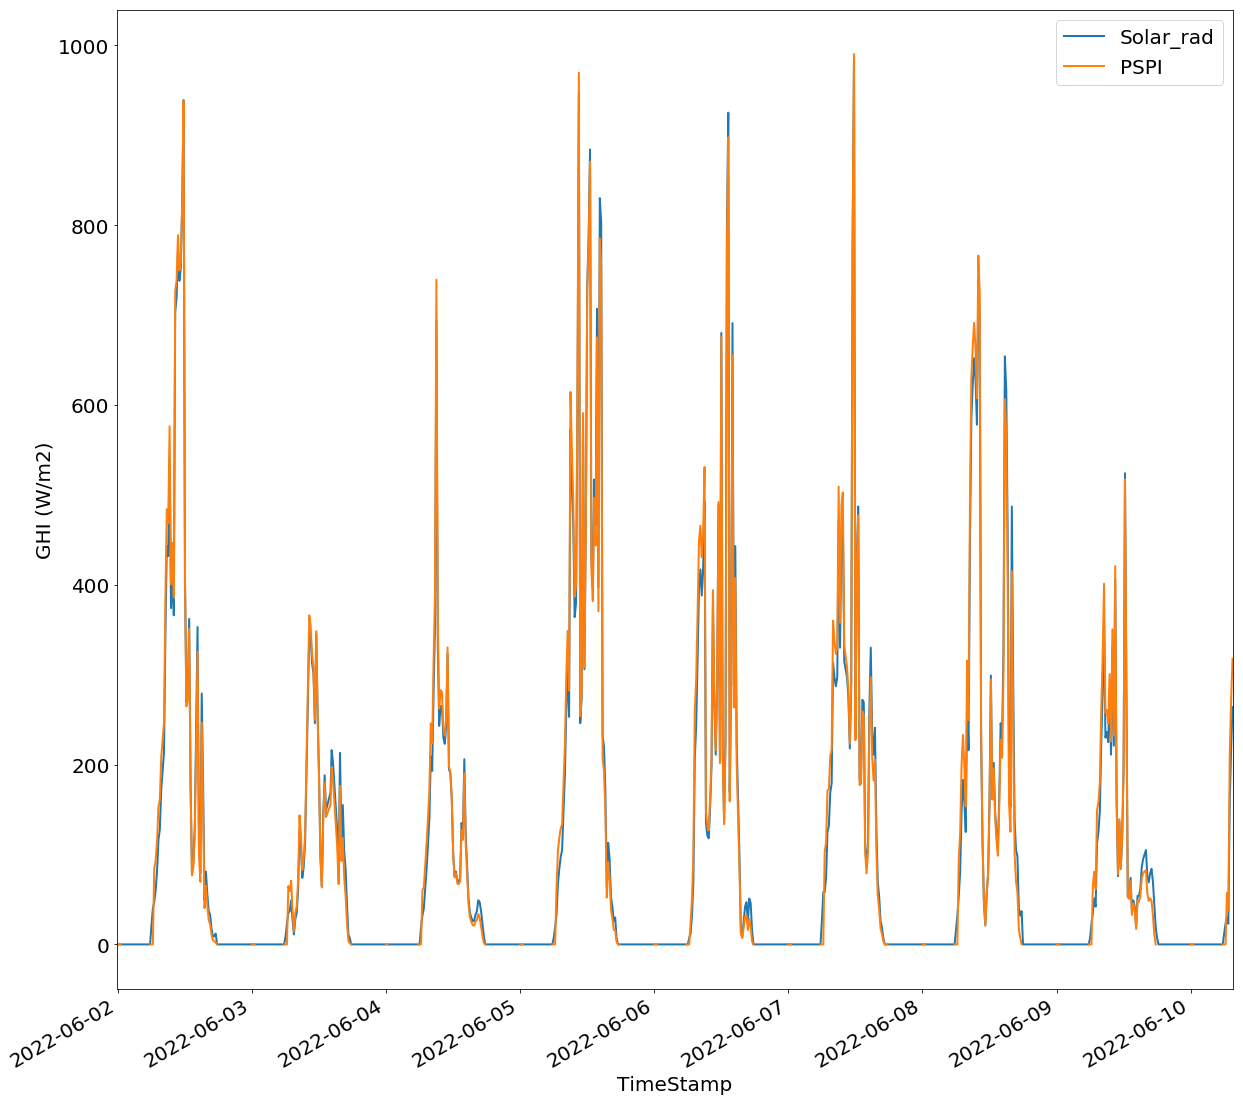

In [368]:
# plotear los datos en simultaneo y guardar

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('font', **font)
ax = Irra_Data[:].plot(figsize=(20,20), linewidth=2)
ax.set_xlabel("TimeStamp")
ax.set_ylabel("GHI (W/m2)")
fig = ax.get_figure()
fig.savefig('Rad_real_vs_Rad_Fore.png',format='png',bbox_inches = 'tight')    # save the figure to file

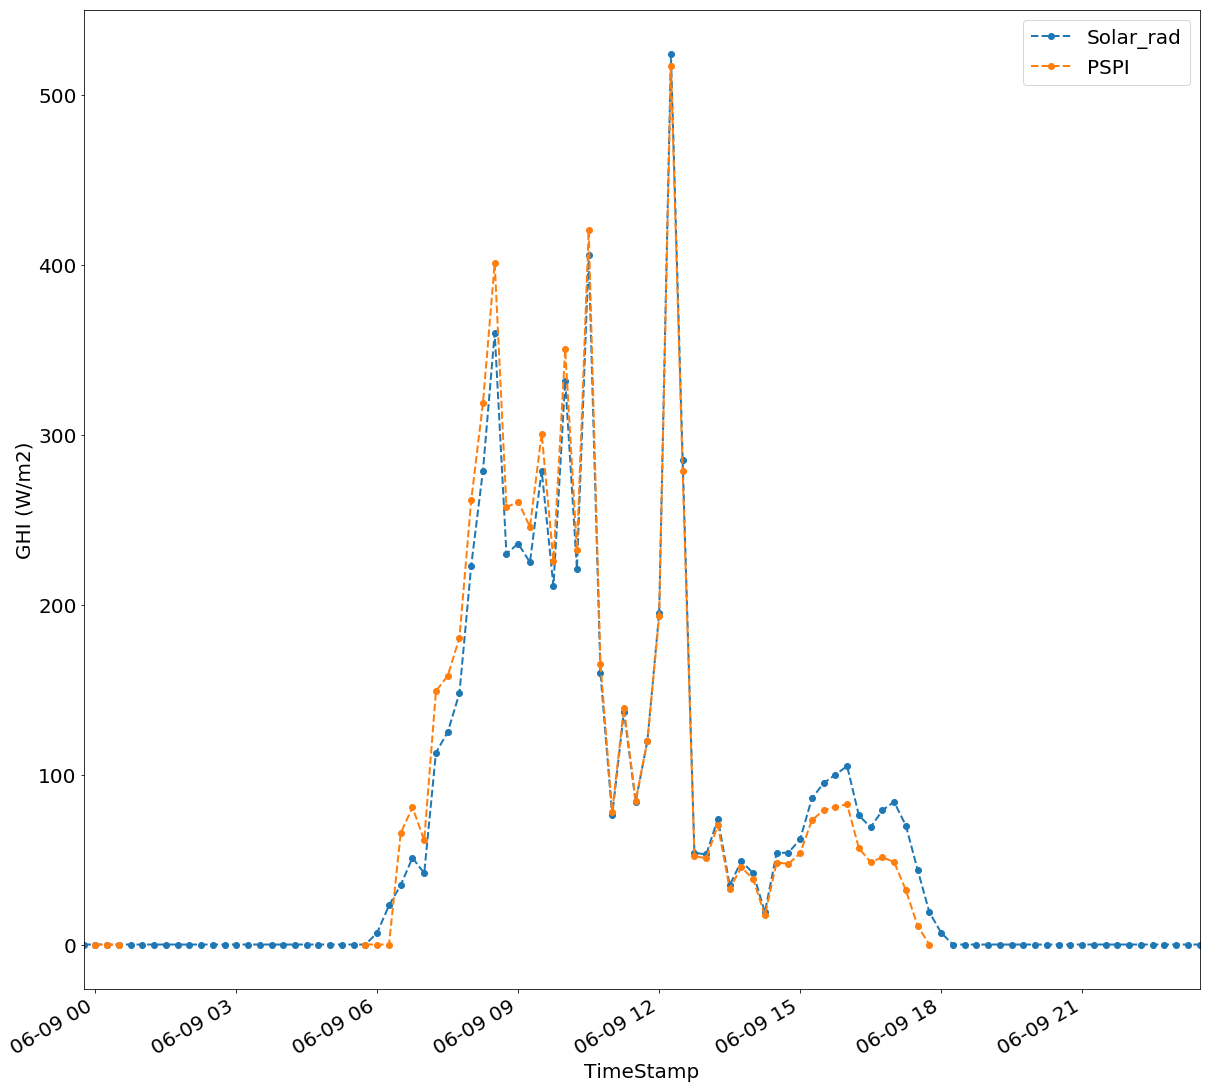

In [370]:
# plotear los datos en simultaneo de un día y guardar

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('font', **font)
dia = 7
ax = Irra_Data[96*dia:96*(dia+1)].plot(figsize=(20,20), linewidth=2, marker='o', linestyle = '--')
ax.set_xlabel("TimeStamp")
ax.set_ylabel("GHI (W/m2)")
fig = ax.get_figure()
fig.savefig('Rad_real_vs_Rad_Fore_Zoomed.png',format='png',bbox_inches = 'tight')    # save the figure to file

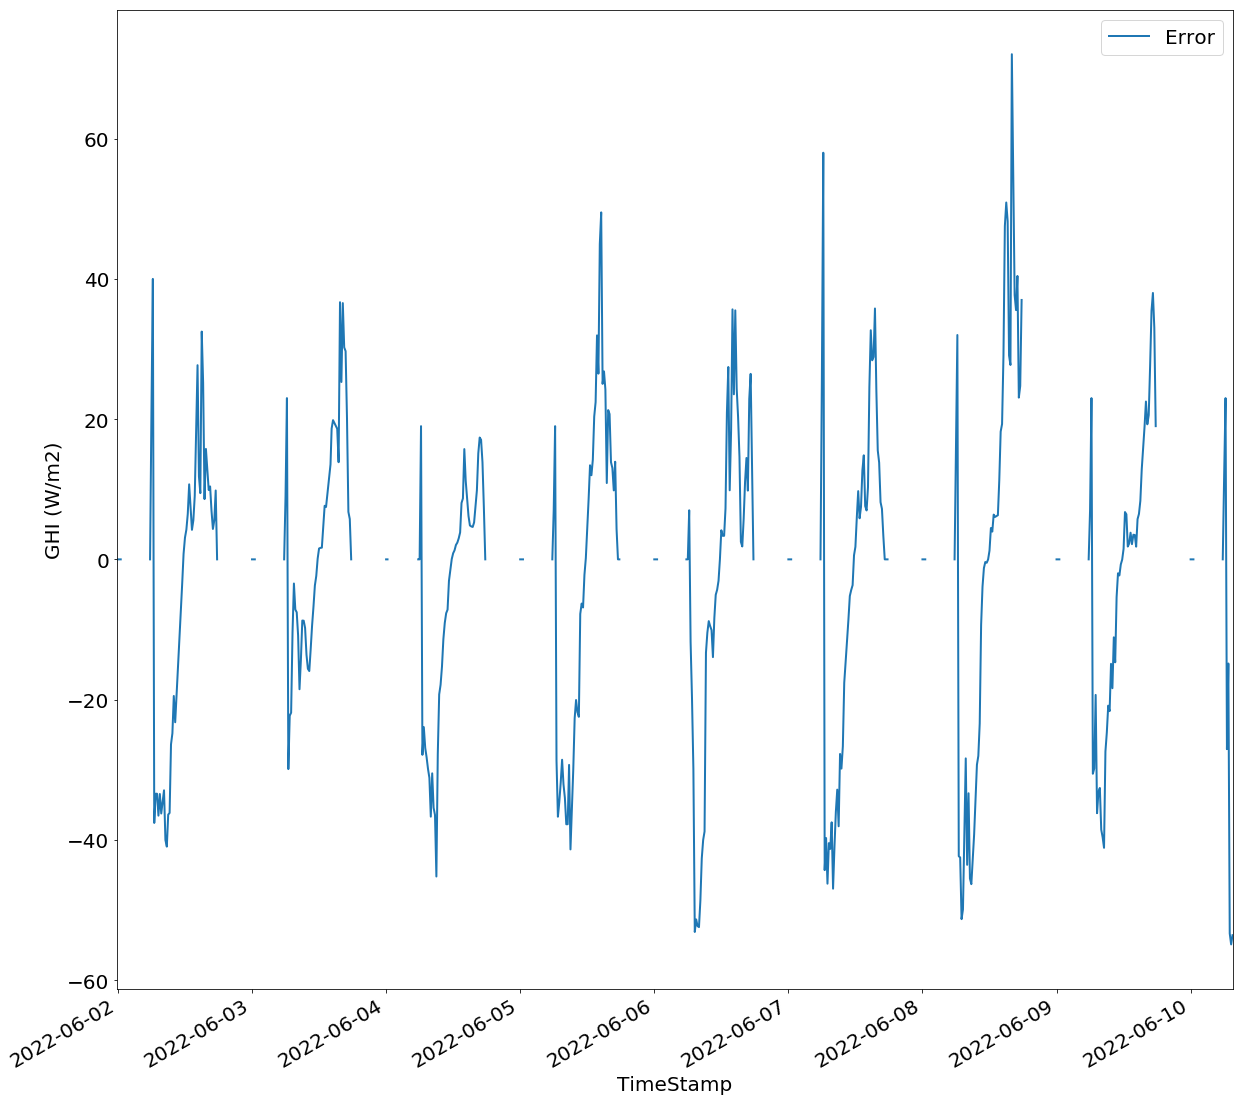

In [371]:
# plotear los datos en simultaneo y guardar

Data_Error = pd.DataFrame()
Data_Error['Error'] = Irra_Data['Solar_rad'] - Irra_Data['PSPI']
Data_Error.index = Irra_Data.index

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('font', **font)
ax = Data_Error[:].plot(figsize=(20,20), linewidth=2)
ax.set_xlabel("TimeStamp")
ax.set_ylabel("GHI (W/m2)")
fig = ax.get_figure()
fig.savefig('Forecasted_Error.png',format='png',bbox_inches = 'tight')    # save the figure to file